## What is this Notebook about?

In this notebook I will try to share different aspects of a NLP problem and well see what difference one makes. This is not a traditional approach to a pproblem but a compairative one.

# Table of Contents
1. [Prepairing the data](#1)
2. [Tokenization](#2)
3. [Problem based Cleaning](#3)
4. [Where embedding might fail](#4)
5. [Traditional data prep and where to use it](#5)
6. [Augmentation](#6)
7. [Resolving StopWords](#7)
8. [A look at Collection extraction](#8)
9. [Similarity Analysis Among Sentences and feature extraction](#9)

<font color="red" size=3>Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from IPython.display import YouTubeVideo
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="1" > </a>
## 1.Prepairing the data

In [2]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin8')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Before doing anything else let's first create folds for our dataset.

In [3]:
def create_folds(X,y):
    
    df['kfold'] = -1
    
    splitter = StratifiedKFold(n_splits=5)
    
    for f, (t_, v_) in enumerate(splitter.split(X, y)):
        
        X.loc[v_, 'kfold'] = f
        
    return X

In [4]:
df = create_folds(df, df['Sentiment'])
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,kfold
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [5]:
df = df[['OriginalTweet', 'Sentiment', 'kfold']]
df.head(2)

,OriginalTweet,Sentiment,kfold
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,advice Talk to your neighbours family to excha...,Positive,0


----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="2" > </a>
## 2.Tokenization
While tokenizing the tweets we have many tokenizers to choose from. Here we have to wise and to see what gives what?

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer, word_tokenize

In [7]:
sentences = df['OriginalTweet'][:5]

In [8]:
for i in sentences[2:3]:
    print("Original:\n")
    print(i)
    print('\nTensorflow Tokenizer\n:')
    a = Tokenizer()
    a.fit_on_texts([i])
    print(a.word_index)
    print("\nTweet Tokenizer:\n")
    print(TweetTokenizer().tokenize(i))
    print('\nNLTK word_tokenizer:\n')
    print(word_tokenize(i))

Original:

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P

Tensorflow Tokenizer
:
{'coronavirus': 1, 'australia': 2, 'woolworths': 3, 'to': 4, 'give': 5, 'elderly': 6, 'disabled': 7, 'dedicated': 8, 'shopping': 9, 'hours': 10, 'amid': 11, 'covid': 12, '19': 13, 'outbreak': 14, 'https': 15, 't': 16, 'co': 17, 'binca9vp8p': 18}

Tweet Tokenizer:

['Coronavirus', 'Australia', ':', 'Woolworths', 'to', 'give', 'elderly', ',', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID', '-', '19', 'outbreak', 'https://t.co/bInCA9Vp8P']

NLTK word_tokenizer:

['Coronavirus', 'Australia', ':', 'Woolworths', 'to', 'give', 'elderly', ',', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID-19', 'outbreak', 'https', ':', '//t.co/bInCA9Vp8P']


As you can see these all yield different results and you have to see which works best for your use case. For now we will use NLTK Tweet-Tokenizer.

In [9]:
tweets = []

for i in tqdm(df['OriginalTweet']):
    
    tweet = TweetTokenizer().tokenize(i)
    tweet = ' '.join(tweet)
    tweets.append(tweet)

In [10]:
for i in tweets[:3]:
    print(i, '\n')

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 

Coronavirus Australia : Woolworths to give elderly , disabled dedicated shopping hours amid COVID - 19 outbreak https://t.co/bInCA9Vp8P 



----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="3" > </a>
## 3.Cleaning (Like thoughtful cleaning)

Ok. Now what ?? <br>
Well, Now we can do data cleaning but before that we have to see how we should do that. And for that I have a very good kernel which I will take insights from. - https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings. I will still write the code but for better explanation and deeper understanding I would highly recommend that notebook and also a couple more from the same author.

In short, we will load the embeddings and see how much vocablary is covered by the embeddings.

In [11]:
from gensim.models import KeyedVectors
from gensim import downloader

embedding_file = '../input/embeddings/GoogleNews-vectors-negative-300d.bin'

embedding_model =  KeyedVectors.load_word2vec_format(embedding_file, binary=True)

In [12]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [13]:
vocab = build_vocab([tweet.split() for tweet in tweets])
print({k: vocab[k] for k in list(vocab)[:5]})


{'@MeNyrbie': 1, '@Phil_Gahan': 1, '@Chrisitv': 3, 'https://t.co/iFz9FAn2Pa': 1, 'and': 23262}


In [14]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [15]:
oov = check_coverage(vocab,embedding_model)


Found embeddings for 37.86% of vocab
Found embeddings for  71.45% of all text


In [16]:
oov[:20]

[('.', 39742),
 ('to', 37455),
 (',', 28642),
 ('and', 23262),
 ('of', 21284),
 ('?', 19010),
 ('a', 18048),
 ('#coronavirus', 12921),
 ('19', 12249),
 ('-', 11511),
 ('!', 7410),
 ('COVID', 7253),
 (':', 6247),
 ('"', 3404),
 ('#COVID19', 3360),
 ('...', 3039),
 ('#Covid_19', 2588),
 (')', 2523),
 ('Covid', 2385),
 ('(', 2380)]

We will remove the punctuation which is not in the embeddings

In [17]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [18]:
for index, tweet in enumerate(tweets):
    
    tweets[index] = clean_text(tweet)


vocab = build_vocab([tweet.split() for tweet in tweets])

In [19]:
oov = check_coverage(vocab,embedding_model)


Found embeddings for 43.95% of vocab
Found embeddings for  81.15% of all text


In [20]:
oov[:20]

[('to', 37568),
 ('tco', 23974),
 ('and', 23283),
 ('of', 21318),
 ('a', 18068),
 ('19', 12701),
 ('COVID', 8581),
 ('COVID19', 3557),
 ('Covid19', 2936),
 ('Covid', 2503),
 ('COVID2019', 1634),
 ('covid19', 1569),
 ('toiletpaper', 1436),
 ('covid', 1197),
 ('CoronaCrisis', 734),
 ('CoronaVirus', 669),
 ('SocialDistancing', 649),
 ('2020', 630),
 ('donÂ', 578),
 ('10', 531)]

So, we did improve a lot but as we can see we still have a significat portion of vocab which still has no embeddings. <br>
The main reason is our use case that is "Covid-19" which itself is a new term and hence the previously trained word embeddings will be useless. So, what can we possibly do in this case. Well, In my opinion we do have one option and that to replace every "COVID" occurance with "crisis" ( Just a word for which we have embedding) also we can replace the "SocialDistancing" with distancing.

In [21]:
"crisis" in embedding_model

True

In [22]:
"distancing" in embedding_model

True

Before we make these changes let's look at which oov words have a significant length.

In [23]:
len(oov)

52885

In [24]:
count = 0
index = 0

while((count != 30) and count < len(oov)):
    
    if len(oov[index][0]) > 3:
        print(oov[index])
        count += 1
        
    index += 1

('COVID', 8581)
('COVID19', 3557)
('Covid19', 2936)
('Covid', 2503)
('COVID2019', 1634)
('covid19', 1569)
('toiletpaper', 1436)
('covid', 1197)
('CoronaCrisis', 734)
('CoronaVirus', 669)
('SocialDistancing', 649)
('2020', 630)
('donÂ', 578)
('CoronavirusPandemic', 414)
('CoronavirusOutbreak', 400)
('canÂ', 370)
('StayHomeSaveLives', 345)
('StayAtHome', 323)
('StayHome', 311)
('panicbuying', 309)
('youÂ', 296)
('socialdistancing', 283)
('CoronaVirusUpdate', 281)
('StopHoarding', 277)
('realDonaldTrump', 247)
('StopPanicBuying', 221)
('covid19UK', 218)
('QuarantineLife', 205)
('behaviour', 195)
('sainsburys', 193)


Oh man I hate cleaning. But well what can I say it's damn important.

In [25]:
to_replace = [('COVID', 'health crisis'),
            ('COVID19', 'health crisis'),
            ('Covid19', 'health crisis'),
            ('Covid', 'health crisis'),
            ('COVID2019', 'health crisis'),
            ('covid19', 'health crisis'),
            ('toiletpaper', 'toilet paper'),
            ('covid', 'health crisis'),
            ('CoronaCrisis', 'health crisis'),
            ('CoronaVirus', 'health crisis'),
            ('SocialDistancing', 'Social distancing'),
            ('2020', 'this year'),
            ('CoronavirusPandemic', 'health crisis'),
            ('CoronavirusOutbreak', 'health crisis'),
            ('StayHomeSaveLives', 'Stay Home Save Lives'),
            ('StayAtHome', 'Stay At Home'),
            ('StayHome', 'Stay Home'),
            ('panicbuying', 'Panic Buying'),
            ('socialdistancing', 'Social Distancing'),
            ('CoronaVirusUpdate', 'health crisis update'),
            ('StopHoarding', 'Stop Hoarding'),
            ('realDonaldTrump', 'real Donald Trump'),
            ('StopPanicBuying', 'Stop Panic Buying'),
            ('covid19UK', 'health crisis'),
            ('QuarantineLife', 'Quarantine life'),
            ('behaviour', 'behave')]

In [26]:
to_replace_dict = {}

for i in to_replace:
    
    to_replace_dict[i[0]] = i[1]

In [27]:
for index, tweet in tqdm(enumerate(tweets)):
    
    cleaned_tweet = []
    
    for word in tweet.split():
        
        if len(word) > 2:
            
            if word in to_replace_dict:              
                cleaned_tweet.append(to_replace_dict[word])
            else:
                cleaned_tweet.append(word)
                
    tweets[index] = ' '.join(cleaned_tweet)

In [28]:
vocab = build_vocab([tweet.split() for tweet in tweets])

In [29]:
oov = check_coverage(vocab,embedding_model)


Found embeddings for 43.39% of vocab
Found embeddings for  88.39% of all text


???? Why are we only at 88%. Let's  look again at our oov words.

In [30]:
count = 0
index = 0

while((count != 30) and count < len(oov)):
    
    if len(oov[index][0]) > 3:
        print(oov[index])
        count += 1
        
    index += 1

('donÂ', 578)
('canÂ', 370)
('youÂ', 296)
('sainsburys', 193)
('ToiletPaper', 186)
('BorisJohnson', 179)
('handsanitizer', 177)
('theyÂ', 159)
('toiletpapercrisis', 158)
('ToiletPaperPanic', 156)
('coronavirusuk', 151)
('staysafe', 140)
('stayhome', 135)
('panicbuyinguk', 129)
('asda', 126)
('DonÂ', 125)
('CoronavirusLockdown', 121)
('doesnÂ', 120)
('isnÂ', 117)
('wonÂ', 116)
('narendramodi', 111)
('2019', 111)
('CoronavirusUSA', 109)
('StaySafe', 108)
('arenÂ', 101)
('ToiletPaperApocalypse', 99)
('cancelled', 99)
('didnÂ', 97)
('PMOIndia', 96)
('SocialDistanacing', 93)


OH MAN I HATE THIS. Why can't they just use normal english and use Space between characters. Also as you can see "can't" is written as "canÂ" and thanks to that I can't use someone else cleaning code. Well, I just want to show you that there are things that you need to take care of.

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="4" > </a>
## 4.Some other examples where embeddings might fail

What we have seen is only one use case. Some time ago there was this competition "Toxic comment classification" which used many emoticons and some vulgur words and so let's have a look at our embedding and see if we have anything related to that.

I apolozise in advance for the mention of these words. I am using them simply to show the importance.

In [31]:
to_check = ['fuck', 'motherfucker', ':)', ":{", 'bastard', ':(']

for i in to_check:
    if i in embedding_model:
        print('yes')
    else:
        print('no')

yes
yes
yes
no
yes
no


As you can see, we may or may not have embeddings for all the words and especially emoticons and nowdays emoticons are really popular. I would recommend to make your own embeddings as it will have better coverage. One more thing is that you could use the pretrained embeddings and then just finetune them. <br> Also let me show you the good thing about tweet_tokenizer of nltk.

In [32]:
TweetTokenizer().tokenize('This word has a :) face')

['This', 'word', 'has', 'a', ':)', 'face']

You see. it recognizes the emoticons and that's really helpful while making embeddings.

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="5" > </a>
## 5.Traditional Data prep and where to use it

By now you could be wondering where is all the Stemming, Lemmatization and etc etc. <br>
Well the thing is we generally don't need those when using pretrained embeddings. Why so? Well let's have a look. 

In [33]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer

word = 'elegant'
stem_word = SnowballStemmer('english').stem(word)
lemma = WordNetLemmatizer().lemmatize(word)

print("Stem word: ", stem_word)
print("\nLemma: ", lemma)

print("\nIs stemmed word present in embedding :", stem_word in embedding_model)
print("\nIs lemma present in embedding :", lemma in embedding_model)

Stem word:  eleg

Lemma:  elegant

Is stemmed word present in embedding : False

Is lemma present in embedding : True


As you can see eleg is not a word and isn't present in the embedding and hence it will only reduce our coverage. let's have a few more examples for understanding it better.

In [34]:
word1 = 'feet'
word2 = 'foot'

print(WordNetLemmatizer().lemmatize(word1))

print(word1 in embedding_model)
print(word2 in embedding_model)

foot
True
True


Well as you can see both feet and foot are present in our embedding and so if do lemmatize the word we will lose the availabe variance and hence we should not do that. <br>
To be truthful you could try lemmatization and see what results it yields and then choose wheather to use it or not.

#### Now the question is where to use this Stemming then ?

Well, the answer to that question is not so simple. I will give you 2 places wher you could use Stemming and Lemmmatization. More likely stemming.
    * 1) We have small data and the pretrained embeddings doesn't have good vocab coverage ( Also you can search for domain wise
    pretrained embeddings and you will likey find one.) or you just don't want to use pretrained embeddings,in such a case stemming will be 
    very useful as it will provide better vectors for words as after stemming the occurance will be incresed significantly.
    
    * 2) Instead of using simple embeddings you could use Tf-idf weighted embeddings and can use stemming in the creation of Tf-idf vectors.

#### Using tf-idf weighted embeddings you you an extra edge in most of the cases. At least I find so.

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="6" > </a>
## 6.Augmentation

Well, this part is really less discussed and I am also not too sure how to deal with it. For all the video and articles/blogs I have read regarding this I found 2 very useful.

* 1) Use Synonyms of words and make new sentences by replacing the word by its synonyms.
* 2) Convert text into another language and then convert it back again to the original language.

In [35]:
!pip install nlpaug

     |████████████████████████████████| 376 kB 190 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [36]:
import nlpaug.augmenter.word as naw

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [37]:
sent = 'All month there hasn been crowding the supermarkets restaurants however reducing all the hours and closing the malls means everyone now using the same entrance and dependent single supermarket manila lockdown covid2019 Philippines https tco HxWs9LAnF9'
print('original: ', sent)
print('\nAugmented: ', naw.SynonymAug(aug_src='wordnet').augment(sent))

original:  All month there hasn been crowding the supermarkets restaurants however reducing all the hours and closing the malls means everyone now using the same entrance and dependent single supermarket manila lockdown covid2019 Philippines https tco HxWs9LAnF9

Augmented:  All month there hasn follow crowding the supermarket eating house however reducing all the hours and closing the malls means everyone at once practice the like entrance and dependent undivided supermarket manila lockdown covid2019 Philippines https tco HxWs9LAnF9


Pretty good write!!! <br>
It would be interseting to explore this library further. I will list a few more such libraries : <br>
    * textattack
    * textaugment

### I would recommend these 2 videos:

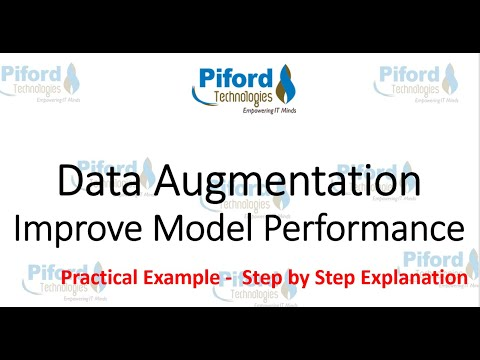

In [38]:
YouTubeVideo('BBR3J2HI5xI')

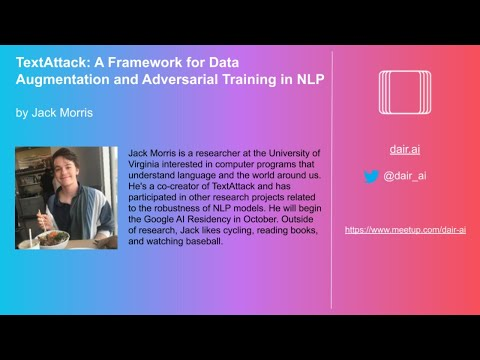

In [39]:
YouTubeVideo('VpLAjOQHaLU')

Now for converting into different language you should see this - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/48038

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="7" > </a>
## 7.Resolving StopWords
Well, there's nothing much to say here but a small remainder "Be careful as 'not' is also a stopword"

In [40]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [41]:
'not' in stop_words

True

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="8" > </a>
## 8.A look at Collection Extraction

A good read - https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

In [42]:
words = ['break the rules', 'free time', 'draw a conclusion', 'keep in mind', 'get ready']

for i in words:
    
    print(i in embedding_model)

False
False
False
False
False


You see these are not individual words but have a meaning due to continuty. You will find the solution in the above mentioned read. <br>
Also, the n-gram approach of BOW and Tf-idf could be very helpful in this context.

----------------------------------------------------------------------------------------------------------------------------------------------
<a id ="9" > </a>
## 9.Similarity Analysis among sentences

USE CASE - A couple years back there was a Competition "Quora Question Pair Similarity.." in which we had to predict given 2 questions whether they are simmilar or not and the following features could be very useful.

A good look - https://github.com/seatgeek/fuzzywuzzy#usage

In [43]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

### Simple Ratio - How much macthing.

In [44]:
fuzz.ratio("this is a test", "this is a test!")

97

### Partial Ration - Does it have a partial match

In [45]:
fuzz.partial_ratio("this is a test", "this is a test!")

100

### Token Sort Ration - After sorting tokens how much match

In [46]:
fuzz.token_sort_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")

84

In [47]:
fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")

100

### Token Set Ratio - Matching Ratio after making a set of tokens

In [48]:
fuzz.token_sort_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")

84

In [49]:
fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")

100

<font color="red" size=3>Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>